In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

import ishneholterlib

from sak.signal import StandardHeader

from functools import partial

def predict_mask(signal, model, window_size=2048, stride=256, thr_dice=0.9, percentile=95, ptg_voting = 0.5, batch_size = 16, use_tqdm=False, normalize=False, norm_threshold=1e-6, filter=False):
    # Preprocess signal
    signal = np.copy(signal).squeeze()
    if signal.ndim == 0:
        return np.array([])
    elif signal.ndim == 1:
        signal = signal[:,None]
    elif signal.ndim == 2:
        if signal.shape[0] < signal.shape[1]:
            signal = signal.T
    else:
        raise ValueError("2 dims max allowed")
        
    # Pad if necessary
    if signal.shape[0] < window_size:
        signal = np.pad(signal,((0,math.ceil(signal.shape[0]/window_size)*window_size-signal.shape[0]),(0,0)),mode='edge')
    if (signal.shape[0]-window_size)%stride != 0:
        signal = np.pad(signal,((0,math.ceil((signal.shape[0]-window_size)/stride)*stride-(signal.shape[0]%window_size)),(0,0)),mode='edge')

    # Get dimensions
    N,L = signal.shape

    # (Optional) Normalize amplitudes
    if normalize:
        # Get signal when it's not flat zero
        norm_signal = signal[np.all(np.abs(np.diff(signal,axis=0,append=0)) >= norm_threshold,axis=1),:]

        # High pass filter normalized signal to avoid issues with baseline wander
        norm_signal = sp.signal.filtfilt(*sp.signal.butter(2, 0.5/250., 'high'),norm_signal, axis=0)

        # Compute amplitude for those segments
        amplitude = np.array(sak.signal.moving_lambda(
            norm_signal,
            256,
            partial(sak.signal.amplitude,axis=0),
            axis=0
        ))
        amplitude = amplitude[np.all(amplitude > norm_threshold,axis=1),]
        amplitude = np.percentile(amplitude, percentile, axis=0)

        # Apply normalization
        signal = signal/amplitude[None,:]

    # (Optional) Filter signal
    if filter:
        signal = sp.signal.filtfilt(*sp.signal.butter(2,   0.5/target_fs, 'high'),signal,axis=0)
        signal = sp.signal.filtfilt(*sp.signal.butter(2, 125.0/target_fs,  'low'),signal,axis=0)

    # Avoid issues with negative strides due to filtering:
    if np.any(np.array(signal.strides) < 0):
        signal = signal.copy()

    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(signal,(window_size,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=float)
    
    # Compute segmentation for all leads independently
    with torch.no_grad():
        iterator = range(0,windowed_signal.shape[0],batch_size)
        if use_tqdm: 
            iterator = tqdm.tqdm(iterator)
        for i in iterator:
            inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).cuda().float()}
            windowed_mask[i:i+batch_size] = model.cuda()(inputs)["sigmoid"].cpu().detach().numpy() > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((N), dtype=int)
    segmentation = np.zeros((3,N))
        
    # Iterate over windows
    for i in range(0,windowed_mask.shape[0],L):
        counter[(i//L)*stride:(i//L)*stride+window_size] += 1
        segmentation[:,(i//L)*stride:(i//L)*stride+window_size] += windowed_mask[i:i+L].sum(0)
    segmentation = ((segmentation/counter) >= (signal.shape[-1]*ptg_voting))

    return segmentation


# Load Models

In [4]:
# Load delineation models
basepath = f'/media/guille/DADES/DADES/Delineator'
model_name = "WNet5LevelsSelfAttentionDiceOnly_20201130125349"
model_type = 'model_best'

# Load models
models = {}
for i in range(5):
    path = os.path.join(basepath, 'TrainedModels', model_name, f'fold_{i+1}', f'{model_type}.model')
    models[f'fold_{i+1}'] = torch.load(path, pickle_module=dill).eval().float()

# Get first fold
model = models["fold_1"]

# Load ECG

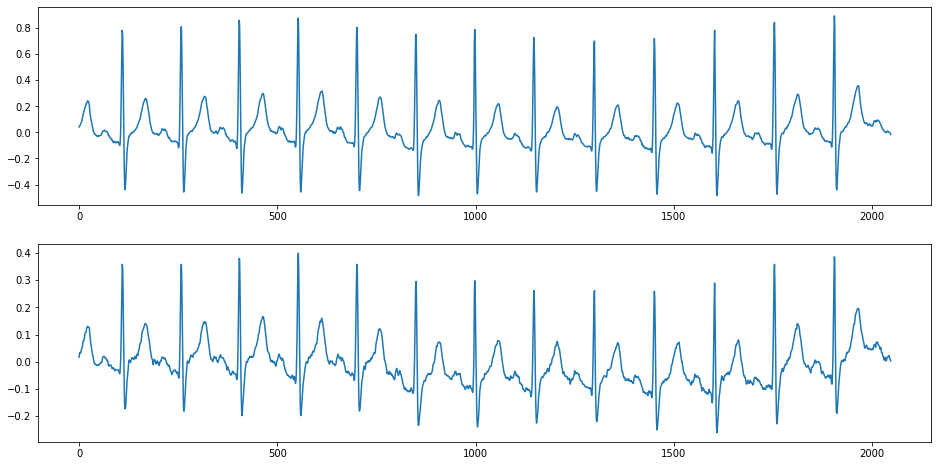

In [9]:
ecg = ishneholterlib.Holter('/home/guille/Descargas/sample_ecg_2channels_24hours (1).ecg')
ecg.load_data(convert=True)
signal = np.array([lead.data for lead in ecg.lead])

f,ax = plt.subplots(nrows=2,figsize=(16,8))

on = 120000
off = on + 2048

ax[0].plot(ecg.lead[0].data[on:off])
ax[1].plot(ecg.lead[1].data[on:off])

In [7]:
target_layer = "encoder_1_lvl5"

In [83]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.encoder_1_lvl5.register_forward_hook(get_activation('encoder_1_lvl5'))
model.encoder_1_lvl5.operations[-2].register_forward_hook(get_activation('1_before_relu'))
model.encoder_2_lvl5.register_forward_hook(get_activation('encoder_2_lvl5'))
model.encoder_2_lvl5.operations[-2].register_forward_hook(get_activation('2_before_relu'))

In [84]:
inp = {"x": torch.tensor(np.vstack((ecg.lead[0].data[on:off],ecg.lead[0].data[on:off])))[:,None,].float().cuda()}
out = model(inp)

In [86]:
tmp1 = activation["encoder_1_lvl5"].cpu().numpy()[0]
tmp1_before = activation["1_before_relu"].cpu().numpy()[0]
tmp2 = activation["encoder_2_lvl5"].cpu().numpy()[0]
tmp2_before = activation["2_before_relu"].cpu().numpy()[0]

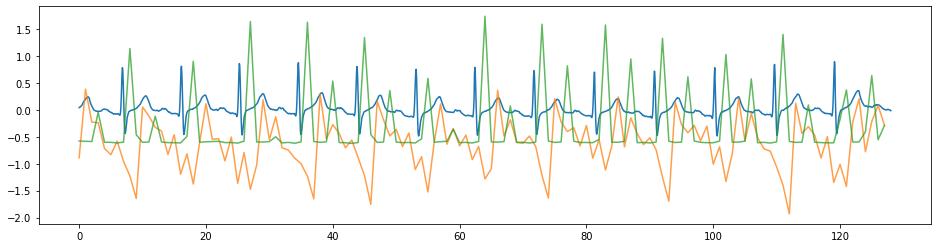

In [150]:
plt.figure(figsize=(16,4))
i = 26
plt.plot(np.linspace(0,128,2048),inp["x"][0,0].cpu().numpy())
plt.plot(tmp1[i],alpha=0.75)
plt.plot(tmp2[i],alpha=0.75)